#### Решение двумерного нестационарного уравнения Навье-Стокса для ламинарного течения несжимаемой жидкости в канале (течение Пуазёйля)

По мотивам статьи (Rao) Physics-informed deep learning for incompressible laminar flows

**Уравнение Навье-Стокса для несжимаемой жидкости, дополненое уравнением неразрывности:**

$
\begin{cases}
    \dfrac{\partial \vec{v}}{\partial t} + \left( \vec{v} \cdot \nabla \right) \vec{v} = \dfrac{1}{\rho} \nabla \cdot \sigma + \vec{f},  \\
    \nabla \cdot \vec{v} = 0,
\end{cases}
$

где 
- $\vec{v} = (u, \mathrm{v})^T$ — векторное поле скоростей,
- $\rho = \mathrm{const}$ — плотность жидкости,
- $\sigma = -p I + \mu \left[ \nabla \vec{v} + (\nabla \vec{v})^T \right]$ — тензор напряжений Коши, $\left[ \sigma_{ij} \right] = M / (L \cdot T^2)$,
- $\mu$ — коэффициент динамической вязкости, $\left[ \mu \right]$ = $M / (L \cdot T)$,
- $\vec{f}$ — сила на единицу массы, $\left[ f \right]$ = $L / T^2$.

<br>

**Обезразмеривание:**

- $\widetilde{L}$ — характерная длина,
- $\widetilde{U}$ — характерная скорость,
- $\widetilde{T} = \widetilde{L} / \widetilde{U}$ — характерное время,
- $\widetilde{\Sigma} = \rho \widetilde{U}^2$
- $\widetilde{F} = \widetilde{U}^2 / \widetilde{L}$ — характерная сила на единицу массы,
- $\widetilde{P} = \rho \widetilde{U}^2$ — характерное давление,
- $\mathrm{Re} = \rho \widetilde{U} \widetilde{L} / \mu $ — число Рейнольдса


Обезразмеренное уравнение Навье-Стокса для несжимаемой жидкости, дополненое уравнением неразрывности:

$
\begin{cases}
    \dfrac{\partial \vec{\widetilde{v}}}{\partial \tilde{t}} + \left( \vec{\widetilde{v}} \cdot \nabla \right) \vec{\widetilde{v}} = \nabla \cdot \widetilde{\sigma} + \vec{\widetilde{f}},  \\
    \nabla \cdot \vec{\widetilde{v}} = 0,
\end{cases}
$

где $\widetilde{\sigma} = -\widetilde{p} I + \dfrac{1}{\mathrm{Re}} \left[ \nabla \vec{\widetilde{v}} + (\nabla \vec{\widetilde{v}})^T \right]$

<br>

**Постановка задачи:**

![alt text](pictures/test.png)

$
\begin{cases}
    \dfrac{\partial \vec{v}}{\partial t} + \left( \vec{v} \cdot \nabla \right) \vec{v} - \dfrac{1}{\rho} \nabla \cdot \sigma = 0,  \\
    \nabla \cdot \vec{v} = 0,
\end{cases}
$

Начальное и краевые условия: 

- $\left. \vec{v} \right|_{t=t_{\mathrm{min}}} = U_\mathrm{max} \left[ 1 - (y/h)^2 \right]$ — начальное условие,
- $\left. \vec{v} \right|_{\Gamma_1} = \left. \vec{v} \right|_{\Gamma_2} = 0$ — условия прилипания,
- $\left. u \right|_{\Gamma_3} = U_\mathrm{max} \left[ 1 - (y/h)^2 \right]$ — профиль течения Пуазейля,
- $\left. p \right|_{\Gamma_4} = 0$,

где $U_\mathrm{max}$ — задаваемый параметр, $h = (y_\mathrm{max} - y_\mathrm{min}) / 2$

Задача решается относительно скалярной функции тока $\psi(x,y)$, такой что $u = \partial_y \psi$, $v = -\partial_x \psi$


In [42]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/MyDrive/Colab Notebooks/NN_pytorch_BVP
# %ls -l

In [43]:
import time
from pathlib import Path
from datetime import datetime
from dataclasses import dataclass, replace, asdict, field, fields
import math
from contextlib import nullcontext
import json

import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import matplotlib.ticker as mticker
import matplotlib.colors as colors
import matplotlib as mpl
import numpy as np
from tqdm import trange

from NN_pytorch_BVP.pinn import MultilayerPerceptronWithFFE, compute_grad_theta_norm, sample_points_3D

mpl.rcParams.update({
    "axes.grid": True,
    "grid.linestyle": "--",
    "grid.linewidth": 0.5,
    "grid.alpha": 1.0,   # optional
})
            
# Для аккуратного масштабирования пределов оси Y во время рендера анимации обучения
def smooth_autoscale_y_hysteresis(ax, y, pad=0.05, alpha_shrink=0.08):
    """
    Smoothly adjust the y-axis limits to follow streaming data.

    Each call computes target y-limits from the current data `y` (with a small
    padding), then updates the axes limits with hysteresis:
      - expand immediately if the new data exceeds the current limits (avoid clipping)
      - shrink gradually toward tighter limits (reduce jitter/"breathing")

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        Axes whose y-limits will be updated.
    y : array-like
        Current y-data (list/NumPy array/torch tensor converted to array).
    pad : float, default=0.05
        Fractional padding added above and below the data range.
    alpha_shrink : float, default=0.08
        Smoothing factor for shrinking (0 < alpha <= 1). Smaller = smoother/slower.
    """
    y = np.asarray(y)
    ymin, ymax = np.nanmin(y), np.nanmax(y)
    if ymin == ymax:
        ymin -= 1.0
        ymax += 1.0

    yr = ymax - ymin
    ymin_t = ymin - pad * yr
    ymax_t = ymax + pad * yr

    cur_ymin, cur_ymax = ax.get_ylim()

    # Expand immediately if needed
    if ymin_t < cur_ymin:
        cur_ymin = ymin_t
    else:  # shrink slowly
        cur_ymin = (1 - alpha_shrink) * cur_ymin + alpha_shrink * ymin_t

    if ymax_t > cur_ymax:
        cur_ymax = ymax_t
    else:
        cur_ymax = (1 - alpha_shrink) * cur_ymax + alpha_shrink * ymax_t

    ax.set_ylim(cur_ymin, cur_ymax)

torch.manual_seed(2008)
 
@dataclass(frozen=True)
class PINNConfig:
    # Problem parameters
    xlims: list[float] = field(default_factory=lambda: [0.0, 2.0])    # x_min, x_max (метры)
    ylims: list[float] = field(default_factory=lambda: [-0.25, 0.25])    # y_min, y_max (метры)
    tlims: list[float] = field(default_factory=lambda: [0.0, 0.11])    # t_min, t_max
    nu: float = 0.00103    # кинематическая вязкость (масло касторовое), м2/с
    rho: float = 960    # плотность (масло касторовое), кг/м3
    u0: float = 1.0    # начальная скорость в центре потока, м/с

    # Для обезразмеривания
    L_wave: float = field(init=False)    # характерная длина, м
    U_wave: float = field(init=False)    # характерная скорость, м/с
    T_wave: float = field(init=False)    # характерное время, с
    P_wave: float = field(init=False)    # характерное давление, Па
    F_wave: float = field(init=False)    # характерная сила на единицу массы, Н/кг
    Re: float = field(init=False)    # число Рейнольдса
    Sigma_wave: float = field(init=False)    # характерное механическое напряжение, Н/м2

    # Model parameters
    device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    init_scheme: str = "glorot_normal"
    layers: list[int] = field(default_factory=lambda: [3, 256, 256, 5])   # (t, x, y) -> (psi, p, sigma_xx, sigma_xy(=sigma_yx), sigma_yy)

    # Training parameters
    results_folder: Path = Path.cwd() / 'runs' / "navier-stokes_2d_incompressible_nonsteady_poiseuille_flow"
    n_epochs: int = 5000
    n_r: int = 80000
    n_ic: int = field(init=False)
    n_bc_x: int = field(init=False)
    n_bc_y: int = field(init=False)
    n_batches: int = 10    # number of batches per epoch
    batch_size_r: int = field(init=False)
    batch_size_ic: int = field(init=False)
    batch_size_bc_x: int = field(init=False)
    batch_size_bc_y: int = field(init=False)
    lambda_r: float = 1.0
    lambda_ic: float = 1.0
    lambda_walls: float = 1.0
    lambda_inlet: float = 1.0
    lambda_outlet: float = 1.0
    lr: float = 1e-3    # initial learning rate
    use_static_training_set: bool = False
    logging_freq: int = 1    # log metrics once every N gradient descent steps

    # Checkpointing
    use_checkpointing: bool = False
    checkpointing_freq: int = 2000    # save model and metrics to the results_folder once every N gradient descent steps

    # Fourier Feature embedding
    use_FFE: bool = False
    FFE_m: int = 100
    FFE_sigma: float = 1.0
    FFE_keep_dims: None | list[int] = None    # Indices of input dimensions to be passed through unchanged

    # Grad norm weighting
    use_grad_norm_weighting: bool = False
    grad_norm_weighting_alpha: float = 0.9
    grad_norm_weighting_freq: int = 200    # update lambdas once every N gradient descent steps

    # Causal weighting
    use_causal_weighting_scheme: bool = False
    causal_m: int = 10
    causal_eps: float = 100.0
    W_logging_freq: int = 100    # log temporal weights and L_t once every N gradient descent steps

    # Video parameters
    render_video: bool = False
    video_fps: int = 30
    video_dpi: int = 100
    video_render_freq: int = 100    # render a frame once every N gradient descent steps

    def __str__(self):
        res = []
        for field in fields(self):
            res.append(f"{field.name}: {getattr(self, field.name)}")
        return "\n".join(res)
    
    def __post_init__(self):
        xlims = self.xlims[:]
        ylims = self.ylims[:]
        tlims = self.tlims[:]

        Lx = xlims[1] - xlims[0]
        Ly = ylims[1] - ylims[0]
        T = tlims[1] - tlims[0]
        tmp = (self.n_r/(Lx*Ly*T))**(2.0/3.0)

        n_ic = math.ceil( Lx*Lx*tmp )
        n_bc_x = max(
            2, 
            2 * math.ceil( Ly*T*tmp )
        )
        n_bc_y = max(
            2, 
            2 * math.ceil( Lx*T*tmp )
        )

        object.__setattr__(self, "n_ic", n_ic)
        object.__setattr__(self, "n_bc_x", n_bc_x)
        object.__setattr__(self, "n_bc_y", n_bc_y)

        batch_size_r = self.n_r / self.n_batches
        batch_size_ic = n_ic / self.n_batches
        if batch_size_ic < 1:
           raise ValueError(f"batch_size_ic turned out to be less than 1 ({batch_size_ic:.1f})." + 
               " Increase n_r or decrease n_batches!")
        batch_size_bc_x = n_bc_x / self.n_batches
        if batch_size_bc_x < 2:
            raise ValueError(f"batch_size_bc_x turned out to be less than 2 ({batch_size_bc_x:.1f})." +
                " Increase n_r or decrease n_batches!")
        batch_size_bc_y = n_bc_y / self.n_batches
        if batch_size_bc_y < 2:
            raise ValueError(f"batch_size_bc_y turned out to be less than 2 ({batch_size_bc_y:.1f})." +
                " Increase n_r or decrease n_batches!")
        object.__setattr__(self, "batch_size_r", math.ceil(batch_size_r))
        object.__setattr__(self, "batch_size_ic", math.ceil(batch_size_ic))
        object.__setattr__(self, "batch_size_bc_x", math.ceil(batch_size_bc_x))
        object.__setattr__(self, "batch_size_bc_y", math.ceil(batch_size_bc_y))

        # Обезразмеривание
        object.__setattr__(self, "L_wave", Ly / 2.0)
        object.__setattr__(self, "U_wave", self.u0)
        object.__setattr__(self, "T_wave", self.L_wave / self.U_wave)
        object.__setattr__(self, "P_wave", self.rho * self.U_wave**2)
        object.__setattr__(self, "F_wave", self.U_wave / self.T_wave)
        object.__setattr__(self, "Re", self.U_wave * self.L_wave / self.nu)
        object.__setattr__(self, "Sigma_wave", self.rho * self.U_wave**2)

class Trainer:
    def __init__(self, model, optimizer, scheduler, cfg: PINNConfig):
        self.model = model.to(cfg.device)
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.cfg = cfg
        self.results_folder = self.cfg.results_folder
        self.results_folder.mkdir(parents=True, exist_ok=True)

        if cfg.use_checkpointing:
            (self.results_folder / "model").mkdir(parents=True, exist_ok=True)
            (self.results_folder / "metrics").mkdir(parents=True, exist_ok=True)

        # Save cfg dataclass object to the results folder as json
        def to_jsonable(x):
            if isinstance(x, Path):
                return str(x)
            if isinstance(x, torch.device):
                return str(x)
            return x
        data = {k: to_jsonable(v) for k, v in asdict(cfg).items()}
        del data["results_folder"]
        (self.results_folder / "config.json").write_text(json.dumps(data, indent=2))

        self.xlims = list(cfg.xlims)
        self.ylims = list(cfg.ylims)
        self.tlims = list(cfg.tlims)
        self.u0 = cfg.u0
        self.h = (cfg.ylims[1] - cfg.ylims[0]) / 2.0
        self.nu = cfg.nu
        self.rho = cfg.rho
        self.L = cfg.xlims[1] - cfg.xlims[0]
        self.device = cfg.device
        self.use_static_training_set = cfg.use_static_training_set

        self.grad_norm_weighting_alpha = cfg.grad_norm_weighting_alpha
        self.use_causal_weighting_scheme = cfg.use_causal_weighting_scheme
        self.causal_m = cfg.causal_m
        self.causal_eps = cfg.causal_eps

    def uvp_exact(self, txy):
        x = txy[:, 1:2]
        y = txy[:, 2:3]

        u = self.u0 * (1.0 - (y/self.h)**2)
        v = torch.zeros_like(u)
        p = 2.0 * self.nu * self.rho * self.u0 / self.h**2 * (self.L - x)

        return torch.cat([u, v, p], dim=1)

    def sample_points(self, n_r: int, n_ic: int, n_bc_x: int, n_bc_y: int):
        T_wave = self.cfg.T_wave
        L_wave = self.cfg.L_wave
        x_min, x_max = self.xlims[0] / L_wave, self.xlims[1] / L_wave
        y_min, y_max = self.ylims[0] / L_wave, self.ylims[1] / L_wave
        t_min, t_max = self.tlims[0] / T_wave, self.tlims[1] / T_wave

        txy_r = sample_points_3D(
            [t_min, x_min, y_min, t_max, x_max, y_max], 
            n_r, scheme="uniform", device=self.device
        )
        txy_r.requires_grad_(True)

        txy_ic = sample_points_3D(
            [t_min, x_min, y_min, t_min, x_max, y_max], 
            n_ic, scheme="uniform", device=self.device
        )
        txy_ic.requires_grad_(True)

        txy_bc_xmin = sample_points_3D(
            [t_min, x_min, y_min, t_max, x_min, y_max], 
            n_bc_x // 2, scheme="uniform", device=self.device
        )
        txy_bc_xmin.requires_grad_(True)
        txy_bc_xmax = sample_points_3D(
            [t_min, x_max, y_min, t_max, x_max, y_max], 
            n_bc_x // 2, scheme="uniform", device=self.device
        )
        txy_bc_xmax.requires_grad_(True)
        txy_bc_ymin = sample_points_3D(
            [t_min, x_min, y_min, t_max, x_max, y_min], 
            n_bc_y // 2, scheme="uniform", device=self.device
        )
        txy_bc_ymin.requires_grad_(True)
        txy_bc_ymax = sample_points_3D(
            [t_min, x_min, y_max, t_max, x_max, y_max], 
            n_bc_y // 2, scheme="uniform", device=self.device
        )
        txy_bc_ymax.requires_grad_(True)

        return txy_r, txy_ic, txy_bc_xmin, txy_bc_xmax, txy_bc_ymin, txy_bc_ymax

    def compute_loss_terms(self, txy_r, txy_ic, txy_bc_xmin, txy_bc_xmax, txy_bc_ymin, txy_bc_ymax,
            lambda_r=1.0, lambda_ic=1.0, lambda_walls=1.0, lambda_inlet=1.0, lambda_outlet=1.0, 
            update_lambdas=False):
        model = self.model
        optimizer = self.optimizer
        use_causal_weighting_scheme = self.use_causal_weighting_scheme
        causal_m = self.causal_m
        causal_eps = self.causal_eps
        t_min, t_max = self.tlims
        Re_inv = 1.0 / self.cfg.Re
        u0 = self.u0 / self.cfg.U_wave
        h = self.h / self.cfg.L_wave
        
        # In this context neural net acts like math map: 
        # (t, x, y) -> (psi, p, sigma_xx, sigma_xy, sigma_yy)

        # Compute loss_r
        mse = lambda x: torch.mean(x**2)
        out_r = model(txy_r)
        psi_r = out_r[:, 0:1]
        p_r = out_r[:, 1:2]
        sigma_xx_r = out_r[:, 2:3]
        sigma_xy_r = out_r[:, 3:4]
        sigma_yy_r = out_r[:, 4:5]
        tmp = torch.autograd.grad(psi_r, txy_r, grad_outputs=torch.ones_like(psi_r), create_graph=True)[0]
        u_r = tmp[:, 2:3]    # d psi / dy
        v_r = -tmp[:, 1:2]    # - d psi / dx
        d_sigma_xx_dx_r = torch.autograd.grad(sigma_xx_r, txy_r, grad_outputs=torch.ones_like(sigma_xx_r), create_graph=True)[0][:, 1:2]
        tmp = torch.autograd.grad(sigma_xy_r, txy_r, grad_outputs=torch.ones_like(sigma_xy_r), create_graph=True)[0]
        d_sigma_xy_dy_r = tmp[:, 2:3]
        d_sigma_yx_dx_r = tmp[:, 1:2]
        d_sigma_yy_dy_r = torch.autograd.grad(sigma_yy_r, txy_r, grad_outputs=torch.ones_like(sigma_yy_r), create_graph=True)[0][:, 2:3]
        tmp = torch.autograd.grad(u_r, txy_r, grad_outputs=torch.ones_like(u_r), create_graph=True)[0]
        du_dx_r = tmp[:, 1:2]
        du_dy_r = tmp[:, 2:3]
        tmp = torch.autograd.grad(v_r, txy_r, grad_outputs=torch.ones_like(v_r), create_graph=True)[0]
        dv_dx_r = tmp[:, 1:2]
        dv_dy_r = tmp[:, 2:3]
        du_dt_r = torch.autograd.grad(u_r, txy_r, grad_outputs=torch.ones_like(u_r), create_graph=True)[0][:, 0:1]
        dv_dt_r = torch.autograd.grad(v_r, txy_r, grad_outputs=torch.ones_like(v_r), create_graph=True)[0][:, 0:1]

        # loss_r = MSE(X axis) + MSE(Y axis) + MSE(sigma_xx) + MSE(sigma_xy) + MSE(sigma_yy) + MSE(p)
        loss_r = mse( du_dt_r + u_r*du_dx_r + v_r*du_dy_r - d_sigma_xx_dx_r - d_sigma_xy_dy_r ) + \
            mse( dv_dt_r + u_r*dv_dx_r + v_r*dv_dy_r - d_sigma_yx_dx_r - d_sigma_yy_dy_r ) + \
            mse( sigma_xx_r + p_r - 2.0*Re_inv*du_dx_r ) + \
            mse( sigma_xy_r - Re_inv*( du_dy_r + dv_dx_r ) ) + \
            mse( sigma_yy_r + p_r - 2.0*Re_inv*dv_dy_r ) + \
            mse( p_r + (sigma_xx_r + sigma_yy_r) / 2.0 )
        # if use_causal_weighting_scheme:
        #     t_flat = txy_r[:, 0].detach().squeeze(-1)
        #     L_t = torch.zeros(causal_m, device=self.device)
        #     h = (t_max - t_min) / causal_m
        #     for i in range(causal_m):
        #         mask = ((t_min + i * h < t_flat) & (t_flat <= t_min + (i + 1) * h))
        #         if mask.any():
        #             L_t[i] = torch.mean(res_r[mask]**2)
        #         else:
        #             L_t[i] = 0.0
        #     M = torch.tril(torch.ones(causal_m, causal_m, device=self.device), diagonal=-1)
        #     W = torch.exp(-causal_eps * (M @ L_t)).detach()
        #     loss_r = (W * L_t).mean()
        # else:
        #     loss_r = torch.mean(res_r**2)
        if update_lambdas:
            optimizer.zero_grad()
            loss_r.backward(retain_graph=True)
            grad_loss_r_theta_norm = compute_grad_theta_norm(model)

        # Compute loss_ic
        out_ic = model(txy_ic)
        psi_ic = out_ic[:, 0:1]
        tmp = torch.autograd.grad(psi_ic, txy_ic, grad_outputs=torch.ones_like(psi_ic), create_graph=False)[0]
        u_ic = tmp[:, 2:3]    # d psi / dy
        v_ic = -tmp[:, 1:2]    # - d psi / dx
        loss_ic = mse(u0*(1.0 - (txy_ic[:, 2:3]/h)**2) - u_ic) + mse(v_ic)
        if update_lambdas:
            optimizer.zero_grad()
            loss_ic.backward(retain_graph=True)
            grad_loss_ic_theta_norm = compute_grad_theta_norm(model)

        # Compute loss_walls
        out_wall_ymin = model(txy_bc_ymin)
        psi_wall_ymin = out_wall_ymin[:, 0:1]
        tmp = torch.autograd.grad(psi_wall_ymin, txy_bc_ymin, grad_outputs=torch.ones_like(psi_wall_ymin), create_graph=True)[0]
        u_wall_ymin = tmp[:, 2:3]
        v_wall_ymin = -tmp[:, 1:2]
        out_wall_ymax = model(txy_bc_ymax)
        psi_wall_ymax = out_wall_ymax[:, 0:1]
        tmp = torch.autograd.grad(psi_wall_ymax, txy_bc_ymax, grad_outputs=torch.ones_like(psi_wall_ymax), create_graph=True)[0]
        u_wall_ymax = tmp[:, 2:3]
        v_wall_ymax = -tmp[:, 1:2]
        loss_walls = mse(u_wall_ymin) + mse(v_wall_ymin) + mse(u_wall_ymax) + mse(v_wall_ymax)
        if update_lambdas:
            optimizer.zero_grad()
            loss_walls.backward(retain_graph=True)
            grad_loss_walls_theta_norm = compute_grad_theta_norm(model)

        # Compute loss_inlet
        out_inlet = model(txy_bc_xmin)
        psi_wall_inlet = out_inlet[:, 0:1]
        tmp = torch.autograd.grad(psi_wall_inlet, txy_bc_xmin, grad_outputs=torch.ones_like(psi_wall_inlet), create_graph=True)[0]
        u_inlet = tmp[:, 2:3]
        v_inlet = -tmp[:, 1:2]
        loss_inlet = mse(u0*(1.0 - (txy_bc_xmin[:, 2:3]/h)**2) - u_inlet) + mse(v_inlet)
        if update_lambdas:
            optimizer.zero_grad()
            loss_inlet.backward(retain_graph=True)
            grad_loss_inlet_theta_norm = compute_grad_theta_norm(model)

        # Compute loss_outlet
        p_outlet = model(txy_bc_xmax)[:, 1:2]
        loss_outlet = mse(p_outlet)
        if update_lambdas:
            optimizer.zero_grad()
            loss_outlet.backward(retain_graph=True)
            grad_loss_outlet_theta_norm = compute_grad_theta_norm(model)

        # Compute new lambdas if needed
        if update_lambdas:
            tmp = grad_loss_r_theta_norm + grad_loss_walls_theta_norm + \
                grad_loss_inlet_theta_norm + grad_loss_outlet_theta_norm + \
                grad_loss_ic_theta_norm
            alpha = self.grad_norm_weighting_alpha
            lambda_r = alpha*lambda_r + (1.0 - alpha) * tmp / grad_loss_r_theta_norm
            lambda_ic = alpha*lambda_ic + (1.0 - alpha) * tmp / grad_loss_ic_theta_norm
            lambda_walls = alpha*lambda_walls + (1.0 - alpha) * tmp / grad_loss_walls_theta_norm
            lambda_inlet = alpha*lambda_inlet + (1.0 - alpha) * tmp / grad_loss_inlet_theta_norm
            lambda_outlet = alpha*lambda_outlet + (1.0 - alpha) * tmp / grad_loss_outlet_theta_norm

        loss = lambda_r*loss_r + lambda_ic*loss_ic + lambda_walls*loss_walls + \
            lambda_inlet*loss_inlet + lambda_outlet*loss_outlet

        return (loss, loss_r, loss_ic, loss_walls, loss_inlet, loss_outlet, 
            lambda_r, lambda_ic, lambda_walls, lambda_inlet, lambda_outlet,
            W if use_causal_weighting_scheme else None, L_t if use_causal_weighting_scheme else None)

    def train(self):
        L_wave = self.cfg.L_wave
        U_wave = self.cfg.U_wave
        T_wave = self.cfg.T_wave
        P_wave = self.cfg.P_wave
        F_wave = self.cfg.F_wave
        Re = self.cfg.Re

        n_epochs = self.cfg.n_epochs
        n_batches = self.cfg.n_batches
        batch_size_r = self.cfg.batch_size_r
        batch_size_ic = self.cfg.batch_size_ic
        batch_size_bc_x = self.cfg.batch_size_bc_x
        batch_size_bc_y = self.cfg.batch_size_bc_y

        use_grad_norm_weighting = self.cfg.use_grad_norm_weighting
        grad_norm_weighting_freq = self.cfg.grad_norm_weighting_freq
        use_causal = self.use_causal_weighting_scheme
        optimizer = self.optimizer
        scheduler = self.scheduler
        lambda_r = self.cfg.lambda_r
        lambda_ic = self.cfg.lambda_ic
        lambda_walls = self.cfg.lambda_walls
        lambda_inlet = self.cfg.lambda_inlet
        lambda_outlet = self.cfg.lambda_outlet
        use_static_training_set = self.use_static_training_set
        n_r = self.cfg.n_r
        n_ic = self.cfg.n_ic
        n_bc_x = self.cfg.n_bc_x
        n_bc_y = self.cfg.n_bc_y
        device = self.device
        W_logging_freq = self.cfg.W_logging_freq
        logging_freq = self.cfg.logging_freq
        t_min, t_max = self.tlims[0] / T_wave, self.tlims[1] / T_wave
        x_min, x_max = self.xlims[0] / L_wave, self.xlims[1] / L_wave
        y_min, y_max = self.ylims[0] / L_wave, self.ylims[1] / L_wave
        causal_m = self.cfg.causal_m
        render_video = self.cfg.render_video
        model = self.model
        use_checkpointing = self.cfg.use_checkpointing
        checkpointing_freq = self.cfg.checkpointing_freq
        results_folder = self.results_folder
        n_iters = n_epochs * n_batches

        # Для логирования
        n_log = n_iters // logging_freq
        n_wlog = n_iters // W_logging_freq
        metrics = {
            "step": torch.arange(0, n_iters, logging_freq),
            "loss": torch.zeros(n_log),
            "loss_r": torch.zeros(n_log),
            "loss_ic": torch.zeros(n_log),
            "loss_walls": torch.zeros(n_log),
            "loss_inlet": torch.zeros(n_log),
            "loss_outlet": torch.zeros(n_log),
            "err_l2": torch.zeros(n_log),
            "rel_err_l2": torch.zeros(n_log),
            "lambda_r": torch.zeros(n_log),
            "lambda_ic": torch.zeros(n_log),
            "lambda_walls": torch.zeros(n_log),
            "lambda_inlet": torch.zeros(n_log),
            "lambda_outlet": torch.zeros(n_log),
            "lr": torch.zeros(n_log),

            "W_step": torch.arange(0, n_iters, W_logging_freq),
            "W": [None] * n_wlog,
            "L_t": [None] * n_wlog
        }

        txy = torch.cartesian_prod(
            torch.linspace(t_min, t_max, 50, device=device),
            torch.linspace(x_min, x_max, 50, device=device),
            torch.linspace(y_min, y_max, 50, device=device)
        )
        txy_rg = txy.clone().requires_grad_(True)
        uvp_exact_arr = self.uvp_exact(
            torch.cat(
                [txy[:, 0:1]*T_wave, txy[:, 1:3]*L_wave], dim=1
            )
        ).detach().cpu()
        uvp_exact_arr[:, 0:2] = uvp_exact_arr[:, 0:2] / U_wave
        uvp_exact_arr[:, 2] = uvp_exact_arr[:, 2] / P_wave
        uvp_exact_arr_l2 = torch.norm(uvp_exact_arr, p=2).item()

        # Video
        video_path = results_folder / ("training_animation_" + ".mp4")
        video_render_freq = self.cfg.video_render_freq

        ### ДЛЯ АНИМАЦИИ ПРОЦЕССА ОБУЧЕНИЯ
        if render_video:
            writer = anim.FFMpegWriter(
                fps=self.cfg.video_fps, 
                codec='libx264', 
                extra_args=['-pix_fmt', 'yuv420p', '-preset', 'ultrafast', "-threads", "0"]
            )
            w, h = plt.rcParams['figure.figsize']
            w *= 0.6
            h *= 0.6

            # model(t)
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(1*w, 2*h), constrained_layout=True)
        
            # # Temporal weights
            # (line1, ) = ax1.plot(torch.arange(causal_m), torch.zeros(causal_m))
            # ax1.set(title="Temporal weights $w_i$", xlabel="$i$", ylabel="$w_i$", ylim=[0, 1.1])

            # # L_t
            # (line2, ) = ax2.semilogy(torch.arange(causal_m), torch.ones(causal_m))
            # ax2.set(title="$\\mathcal{L}_{r}^{i}$", xlabel="$i$", ylabel="$\\mathcal{L}_{r}^{i}$", ylim=[1e-5, 1])

        pbar = trange(n_iters, desc="Training model")
        with writer.saving(fig, video_path, dpi=self.cfg.video_dpi) if render_video else nullcontext():
            for iter in pbar:
                i_batch = iter % n_batches    # batch index inside the current epoch
                if i_batch == 0 or (not use_static_training_set):
                    txy_r, txy_ic, txy_bc_xmin, txy_bc_xmax, txy_bc_ymin, txy_bc_ymax = self.sample_points(n_r, n_ic, n_bc_x, n_bc_y)
                if use_static_training_set:    # re-leaf tensors
                    txy_r = txy_r.detach().requires_grad_(True)
                    txy_ic = txy_ic.detach().requires_grad_(True)
                    txy_bc_xmin = txy_bc_xmin.detach().requires_grad_(True)
                    txy_bc_xmax = txy_bc_xmax.detach().requires_grad_(True)
                    txy_bc_ymin = txy_bc_ymin.detach().requires_grad_(True)
                    txy_bc_ymax = txy_bc_ymax.detach().requires_grad_(True)
                loss, loss_r, loss_ic, loss_walls, loss_inlet, loss_outlet, lambda_r, lambda_ic, lambda_walls, lambda_inlet, lambda_outlet, W, L_t = self.compute_loss_terms(
                    txy_r[i_batch*batch_size_r:(i_batch+1)*batch_size_r], 
                    txy_ic[i_batch*batch_size_ic:(i_batch+1)*batch_size_ic], 
                    txy_bc_xmin[i_batch*(batch_size_bc_x//2):(i_batch+1)*(batch_size_bc_x//2)], 
                    txy_bc_xmax[i_batch*(batch_size_bc_x//2):(i_batch+1)*(batch_size_bc_x//2)], 
                    txy_bc_ymin[i_batch*(batch_size_bc_y//2):(i_batch+1)*(batch_size_bc_y//2)], 
                    txy_bc_ymax[i_batch*(batch_size_bc_y//2):(i_batch+1)*(batch_size_bc_y//2)], 
                    lambda_r=lambda_r, lambda_ic=lambda_ic, 
                    lambda_walls=lambda_walls, lambda_inlet=lambda_inlet, lambda_outlet=lambda_outlet, 
                    update_lambdas = use_grad_norm_weighting and iter % grad_norm_weighting_freq == 0)

                self.optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                scheduler.step()

                if use_causal and iter % W_logging_freq == 0:
                    i = iter // W_logging_freq
                    metrics["W"][i] = W.detach().cpu().numpy()
                    metrics["L_t"][i] = L_t.detach().cpu().numpy()
                
                if iter % logging_freq == 0:
                    i = iter // logging_freq
                    metrics["loss"][i] = loss.item()
                    metrics["loss_r"][i] = loss_r.item()
                    metrics["loss_ic"][i] = loss_ic.item()
                    metrics["loss_walls"][i] = loss_walls.item()
                    metrics["loss_inlet"][i] = loss_inlet.item()
                    metrics["loss_outlet"][i] = loss_outlet.item()
                    model_output = model(txy_rg)
                    psi = model_output[:, 0:1]
                    tmp = torch.autograd.grad(psi, txy_rg, grad_outputs=torch.ones_like(psi), create_graph=False)[0]
                    u, v, p = tmp[:, 2:3], -tmp[:, 1:2], model_output[:, 1:2]
                    uvp_model = torch.cat([u, v, p], dim=1).detach().cpu()
                    metrics["err_l2"][i] = torch.norm(uvp_exact_arr - uvp_model, p=2).item()
                    metrics["rel_err_l2"][i] = metrics["err_l2"][i] / uvp_exact_arr_l2 * 100
                    metrics["lambda_r"][i] = lambda_r
                    metrics["lambda_ic"][i] = lambda_ic
                    metrics["lambda_walls"][i] = lambda_walls
                    metrics["lambda_inlet"][i] = lambda_inlet
                    metrics["lambda_outlet"][i] = lambda_outlet
                    metrics["lr"][i] = optimizer.param_groups[0]["lr"]

                    pbar.set_postfix({
                        'loss': metrics["loss"][i].item(),
                        "err_l2": metrics["err_l2"][i].item(),
                        "rel_err_l2": metrics["rel_err_l2"][i].item(),
                        'lambda_r': metrics["lambda_r"][i].item(),
                        'lambda_walls': metrics["lambda_walls"][i].item(),
                        'lambda_ic': metrics["lambda_ic"][i].item(),
                        'lambda_inlet': metrics["lambda_inlet"][i].item(),
                        'lambda_outlet': metrics["lambda_outlet"][i].item()
                    })

                # Рендер кадра анимации
                if render_video and iter % video_render_freq == 0:
                    # if use_causal:
                    #     line1.set_ydata(W.detach().cpu())
                    #     line2.set_ydata(L_t.detach().cpu())
                    writer.grab_frame()

                if use_checkpointing and ( (iter + 1) % checkpointing_freq == 0 or (iter + 1) == n_iters ):
                    # save model
                    model_path = results_folder / "model" / ("model_epoch=" + str(iter//n_batches + 1) + 
                        "_batch=" + str(iter % n_batches + 1) + ".pth")
                    MultilayerPerceptronWithFFE.save(model, model_path)    

                    # save metrics
                    metrics_path = results_folder / "metrics" / ("metrics_epoch=" + str(iter//n_batches + 1) +
                        "_batch=" + str(iter % n_batches + 1) + ".pth")
                    torch.save(metrics, metrics_path)

        return metrics
    
    def render_metrics_plots(self, metrics: dict, show=True, save_to_disk: bool = False, fmt: str ="png",
            video_fps: int = 30, video_length: float = 3.0, video_dpi: int = 150):
        if save_to_disk:
            plot_path = self.results_folder / "plots"
            plot_path.mkdir(parents=True, exist_ok=True)

        w, h = plt.rcParams['figure.figsize']
        t_min, t_max = self.tlims
        x_min, x_max = self.xlims
        y_min, y_max = self.ylims
        device = self.device

        def show_plot(fig, show):
            if not show:
                plt.close(fig)

        def save_fig(fig, save_path: Path, dpi: int = 300):
            if save_to_disk:
                fig.savefig(save_path, dpi=dpi)
        
        # Losses
        fig, ax = plt.subplots()
        ax.set(title="Losses", xlabel="grad step")
        ax.semilogy(metrics["step"], metrics["loss"], label="loss")
        ax.semilogy(metrics["step"], metrics["loss_r"], label="loss_r")
        ax.semilogy(metrics["step"], metrics["loss_ic"], label="loss_ic")
        ax.semilogy(metrics["step"], metrics["loss_walls"], label="loss_walls")
        ax.semilogy(metrics["step"], metrics["loss_inlet"], label="loss_inlet")
        ax.semilogy(metrics["step"], metrics["loss_outlet"], label="loss_outlet")
        ax.legend()
        show_plot(fig, show)
        save_fig(fig, plot_path / ("losses" + "." + fmt))
        fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(2*w, 3*h))
        ax1.semilogy(metrics["step"], metrics["loss"], label="loss", color='C0')
        ax1.legend()
        ax2.semilogy(metrics["step"], metrics["loss_r"], label="loss_r", color='C1')
        ax2.legend()
        ax3.semilogy(metrics["step"], metrics["loss_ic"], label="loss_ic", color='C2')
        ax3.legend()
        ax4.semilogy(metrics["step"], metrics["loss_walls"], label="loss_walls", color='C3')
        ax4.legend()
        ax5.semilogy(metrics["step"], metrics["loss_inlet"], label="loss_inlet", color='C4')
        ax5.legend()
        ax6.semilogy(metrics["step"], metrics["loss_outlet"], label="loss_outlet", color='C5')
        ax6.legend()
        show_plot(fig, show)
        save_fig(fig, plot_path / ("losses_separate" + "." + fmt))

        # Error
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2*w, h))
        ax1.plot(metrics["step"], metrics["err_l2"])
        ax1.set(title="Error L2 norm", xlabel="grad step")
        ax2.plot(metrics["step"], metrics["rel_err_l2"])
        ax2.set(title="Relative error L2 norm", xlabel="grad step", ylabel="%")
        show_plot(fig, show)
        save_fig(fig, plot_path / ("error" + "." + fmt))

        # Lambdas
        if self.cfg.use_grad_norm_weighting:
            fig, ax = plt.subplots()
            ax.plot(metrics["step"], metrics["lambda_r"], label="lambda_r")
            ax.plot(metrics["step"], metrics["lambda_walls"], label="lambda_walls")
            ax.plot(metrics["step"], metrics["lambda_inlet"], label="lambda_inlet")
            ax.plot(metrics["step"], metrics["lambda_outlet"], label="lambda_outlet")
            ax.set_xlabel("grad step")
            ax.legend()
            show_plot(fig, show)
            save_fig(fig, plot_path / ("lambdas" + "." + fmt))

        # # Temporal weights
        # if self.cfg.use_causal_weighting_scheme:
        #     W = np.stack(metrics["W"])
        #     t = np.arange(W.shape[1])
        #     fig, ax = plt.subplots()
        #     pm = ax.pcolormesh(t, metrics["W_step"], W, shading='auto', cmap='binary')
        #     cbar = fig.colorbar(pm, ax=ax)
        #     ax.set(title="Temporal weights $w_i$ over training", xlabel="$i$", ylabel="gradient step")
        #     show_plot(fig, show)
        #     save_fig(fig, plot_path / ("temporal_weights" + "." + fmt))

        # # L_t
        # if self.cfg.use_causal_weighting_scheme:
        #     L_t = np.stack(metrics["L_t"])
        #     t = np.arange(L_t.shape[1])
        #     fig, ax = plt.subplots()
        #     pm = ax.pcolormesh(t, metrics["W_step"], L_t, shading='auto', cmap='binary',
        #         norm=colors.LogNorm())
        #     cbar = fig.colorbar(pm, ax=ax)
        #     ax.set(title="$\\mathcal{L}_{r}^{i}$ for gradient steps", xlabel="$i$", ylabel="grad step")
        #     show_plot(fig, show)
        #     save_fig(fig, plot_path / ("l_t" + "." + fmt))

        # Learning rate
        fig, ax = plt.subplots()
        ax.set(title="Learning rate", xlabel="grad step")
        ax.semilogy(metrics["step"], metrics["lr"])
        show_plot(fig, show)
        save_fig(fig, plot_path / ("learning_rate" + "." + fmt))

        L_wave = self.cfg.L_wave
        T_wave = self.cfg.T_wave
        U_wave = self.cfg.U_wave
        P_wave = self.cfg.P_wave

        # Reference vs model solution
        txy = torch.cartesian_prod(
            torch.linspace(t_min, t_max, 80),
            torch.linspace(x_min, x_max, 100),
            torch.linspace(y_min, y_max, 100)
        )
        out_exact_arr = self.uvp_exact(txy)
        u_exact_arr, v_exact_arr, p_exact_arr = out_exact_arr[:, 0], out_exact_arr[:, 1], out_exact_arr[:, 2]
        model = self.model.to("cpu")
        txy_wave = torch.cat(
            [txy[:, 0:1]/T_wave, txy[:, 1:3]/L_wave], dim=1
        ).requires_grad_(True)
        out_model_arr = model(txy_wave)
        psi_model_arr = out_model_arr[:, 0:1]
        tmp = torch.autograd.grad(psi_model_arr, txy_wave, grad_outputs=torch.ones_like(psi_model_arr), create_graph=False)[0]
        u_model = tmp[:, 2]*U_wave
        v_model = -tmp[:, 1]*U_wave
        p_model = out_model_arr[:, 1]*P_wave
        
        u_exact_min, u_exact_max = u_exact_arr.min(), u_exact_arr.max()
        v_exact_min, v_exact_max = v_exact_arr.min(), v_exact_arr.max()
        p_exact_min, p_exact_max = p_exact_arr.min(), p_exact_arr.max()

        w, h = plt.rcParams['figure.figsize']
        w *= 0.6
        h *= 0.6
        det_cpu = lambda x: x.detach().cpu()
        fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, 
            figsize=(3*w, 3*h), constrained_layout=True)
        
        # Plot exact solution
        with torch.no_grad():
            pc1 = ax1.tripcolor(
                det_cpu(txy[:, 1]), det_cpu(txy[:, 2]), u_exact_arr,
                vmin=u_exact_min, vmax=u_exact_max, shading="gouraud", cmap="coolwarm")
            ax1.set(title="u exact", xlabel="$x$", ylabel="$y$", xlim=self.xlims, ylim=self.ylims)
            fig.colorbar(pc1, ax=ax1)
            pc2 = ax2.tripcolor(
                det_cpu(txy[:, 1]), det_cpu(txy[:, 2]), v_exact_arr, 
                vmin=v_exact_min, vmax=v_exact_max, shading="gouraud", cmap="coolwarm")
            ax2.set(title="v exact", xlabel="$x$", ylabel="$y$", xlim=self.xlims, ylim=self.ylims)
            fig.colorbar(pc2, ax=ax2)
            pc3 = ax3.tripcolor(
                det_cpu(txy[:, 1]), det_cpu(txy[:, 2]), p_exact_arr, 
                vmin=p_exact_min, vmax=p_exact_max, shading="gouraud", cmap="binary")
            ax3.set(title="p exact", xlabel="$x$", ylabel="$y$", xlim=self.xlims, ylim=self.ylims)
            fig.colorbar(pc3, ax=ax3)

            # Plot model solution
            pc4 = ax4.tripcolor(
                det_cpu(txy[:, 1]), det_cpu(txy[:, 2]), u_model,
                vmin=u_exact_min, vmax=u_exact_max, shading="gouraud", cmap="coolwarm")
            ax4.set(title="u model", xlabel="$x$", ylabel="$y$", xlim=self.xlims, ylim=self.ylims)
            fig.colorbar(pc4, ax=ax4)
            pc5 = ax5.tripcolor(
                det_cpu(txy[:, 1]), det_cpu(txy[:, 2]), v_model, 
                vmin=v_exact_min, vmax=v_exact_max, shading="gouraud", cmap="coolwarm")
            ax5.set(title="v model", xlabel="$x$", ylabel="$y$", xlim=self.xlims, ylim=self.ylims)
            fig.colorbar(pc5, ax=ax5)
            pc6 = ax6.tripcolor(
                det_cpu(txy[:, 1]), det_cpu(txy[:, 2]), p_model, 
                vmin=p_exact_min, vmax=p_exact_max, shading="gouraud", cmap="binary")
            ax6.set(title="p model", xlabel="$x$", ylabel="$y$", xlim=self.xlims, ylim=self.ylims)
            fig.colorbar(pc6, ax=ax6)

            # Plot error
            u_error = torch.abs(u_model - u_exact_arr)
            pc7 = ax7.tripcolor(
                det_cpu(txy[:, 1]), det_cpu(txy[:, 2]), u_error,
                vmin=u_error.min(), vmax=u_error.max(), shading="gouraud", cmap="binary")
            ax7.set(title="abs(u_model - u_exact)", xlabel="$x$", ylabel="$y$", xlim=self.xlims, ylim=self.ylims)
            fig.colorbar(pc7, ax=ax7)
            v_error = torch.abs(v_model - v_exact_arr)
            pc8 = ax8.tripcolor(
                det_cpu(txy[:, 1]), det_cpu(txy[:, 2]), v_error, 
                vmin=v_error.min(), vmax=v_error.max(), shading="gouraud", cmap="binary")
            ax8.set(title="abs(v_model - v_exact)", xlabel="$x$", ylabel="$y$", xlim=self.xlims, ylim=self.ylims)
            fig.colorbar(pc8, ax=ax8)
            p_error = torch.abs(p_model - p_exact_arr)
            pc9 = ax9.tripcolor(
                det_cpu(txy[:, 1]), det_cpu(txy[:, 2]), p_error, 
                vmin=p_error.min(), vmax=p_error.max(), shading="gouraud", cmap="binary")
            ax9.set(title="abs(p_model - p_exact)", xlabel="$x$", ylabel="$y$", xlim=self.xlims, ylim=self.ylims)
            fig.colorbar(pc9, ax=ax9)

            show_plot(fig, show)
            save_fig(fig, plot_path / ("model_vs_exact_solution" + "." + fmt))

            writer = anim.FFMpegWriter(
                fps=video_fps, 
                codec='libx264', 
                extra_args=['-pix_fmt', 'yuv420p', '-preset', 'ultrafast', "-threads", "0"]
            )
            
            n_frames = math.ceil(video_fps * video_length)
            pbar = trange(n_frames, desc="Render output video")
            t_step = (t_max - t_min) / (n_frames - 1)
            n_points = txy.shape[0]
            ones_arr = torch.ones(n_points)
            with writer.saving(fig, self.results_folder / "model_vs_exact_solution.mp4", dpi=video_dpi):
                for iter in pbar:
                    time = t_min + t_step * iter
                    fig.suptitle(f"time = {time:10.2f}")

                    # Reference solution
                    txy[:, 0] = ones_arr * time
                    out_exact_arr = self.uvp_exact(txy)
                    u_exact_arr = out_exact_arr[:, 0]
                    v_exact_arr = out_exact_arr[:, 1]
                    p_exact_arr = out_exact_arr[:, 2]

                    # Model solution
                    with torch.enable_grad():
                        txy_wave.requires_grad_(False)
                        txy_wave[:, 0] = ones_arr * time/T_wave
                        txy_wave.requires_grad_(True)
                        out_model_arr = model(txy_wave)
                        psi_model_arr = out_model_arr[:, 0:1]
                        tmp = torch.autograd.grad(psi_model_arr, txy_wave, 
                            grad_outputs=torch.ones_like(psi_model_arr), create_graph=False)[0]
                        u_model = tmp[:, 2]*U_wave
                        v_model = -tmp[:, 1]*U_wave
                        p_model = out_model_arr[:, 1]*P_wave

                    # Update reference solution
                    pc1.set_array(u_exact_arr)
                    pc2.set_array(v_exact_arr)
                    pc3.set_array(p_exact_arr)

                    # Update model solution
                    pc4.set_array(u_model)
                    pc5.set_array(v_model)
                    pc6.set_array(p_model)

                    # Update error
                    pc7.set_array(torch.abs(u_exact_arr - u_model))
                    pc8.set_array(torch.abs(v_exact_arr - v_model))
                    pc9.set_array(torch.abs(p_exact_arr - p_model))
                    
                    writer.grab_frame()

Запуск обучения без каких-либо улучшений

xlims: [0.0, 2.0]
ylims: [-0.25, 0.25]
tlims: [0.0, 0.11]
nu: 0.00103
rho: 960
u0: 1.0
L_wave: 0.25
U_wave: 1.0
T_wave: 0.25
P_wave: 960.0
F_wave: 4.0
Re: 242.71844660194174
Sigma_wave: 960.0
device: cpu
init_scheme: glorot_normal
layers: [3, 256, 256, 5]
results_folder: c:\Учёба\adf\Скрипты\NN_pytorch_BVP\runs\navier-stokes_2d_incompressible_nonsteady_poiseuille_flow\baseline
n_epochs: 1000
n_r: 10000
n_ic: 8088
n_bc_x: 224
n_bc_y: 890
n_batches: 10
batch_size_r: 1000
batch_size_ic: 809
batch_size_bc_x: 23
batch_size_bc_y: 89
lambda_r: 1.0
lambda_ic: 1.0
lambda_walls: 1.0
lambda_inlet: 1.0
lambda_outlet: 1.0
lr: 0.001
use_static_training_set: False
logging_freq: 200
use_checkpointing: True
checkpointing_freq: 2000
use_FFE: False
FFE_m: 100
FFE_sigma: 1.0
FFE_keep_dims: None
use_grad_norm_weighting: False
grad_norm_weighting_alpha: 0.9
grad_norm_weighting_freq: 200
use_causal_weighting_scheme: False
causal_m: 10
causal_eps: 100.0
W_logging_freq: 100
render_video: False
video_fps: 30
vi

Render output video: 100%|██████████| 90/90 [05:50<00:00,  3.89s/it]


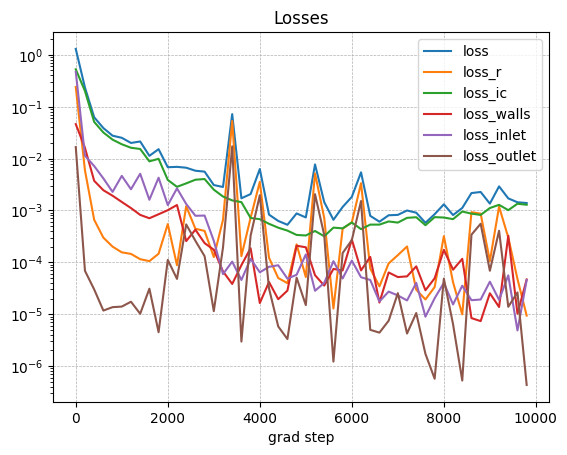

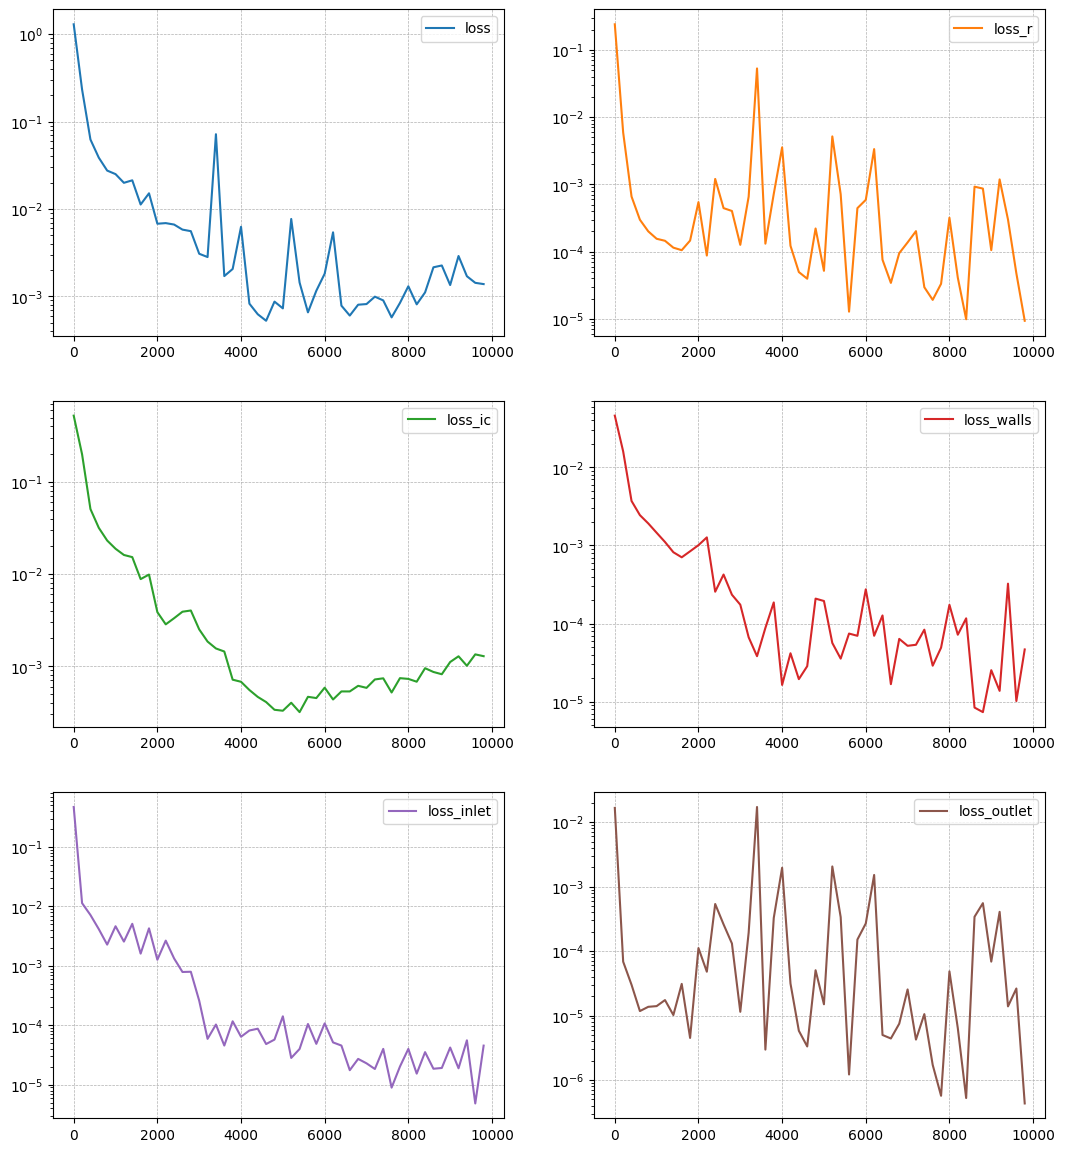

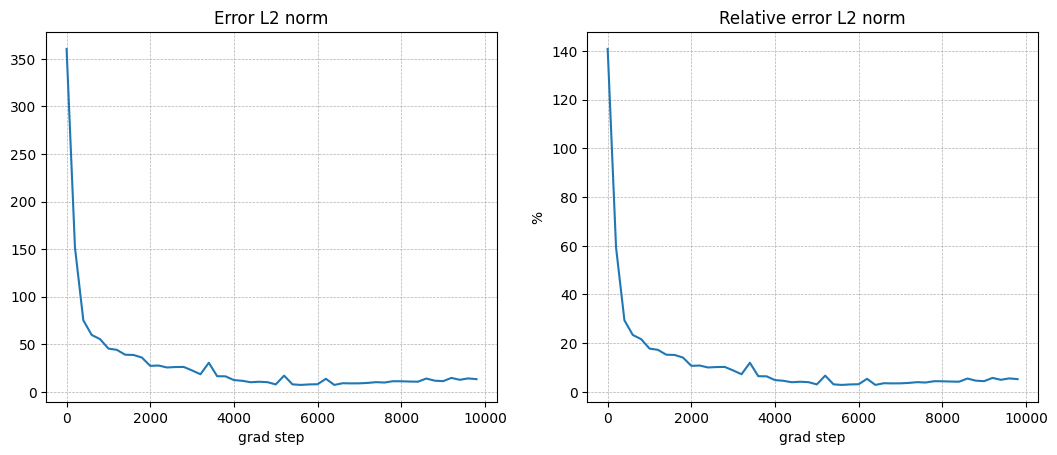

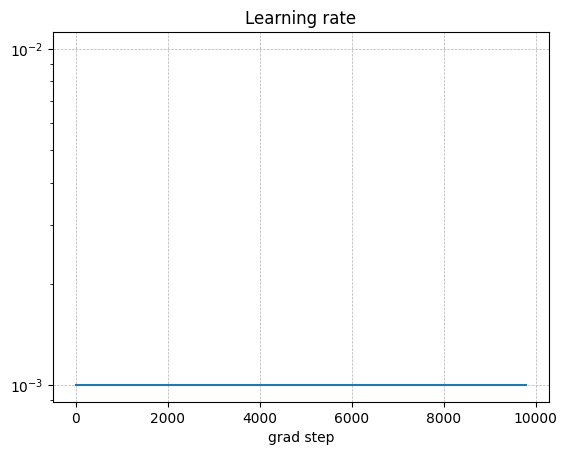

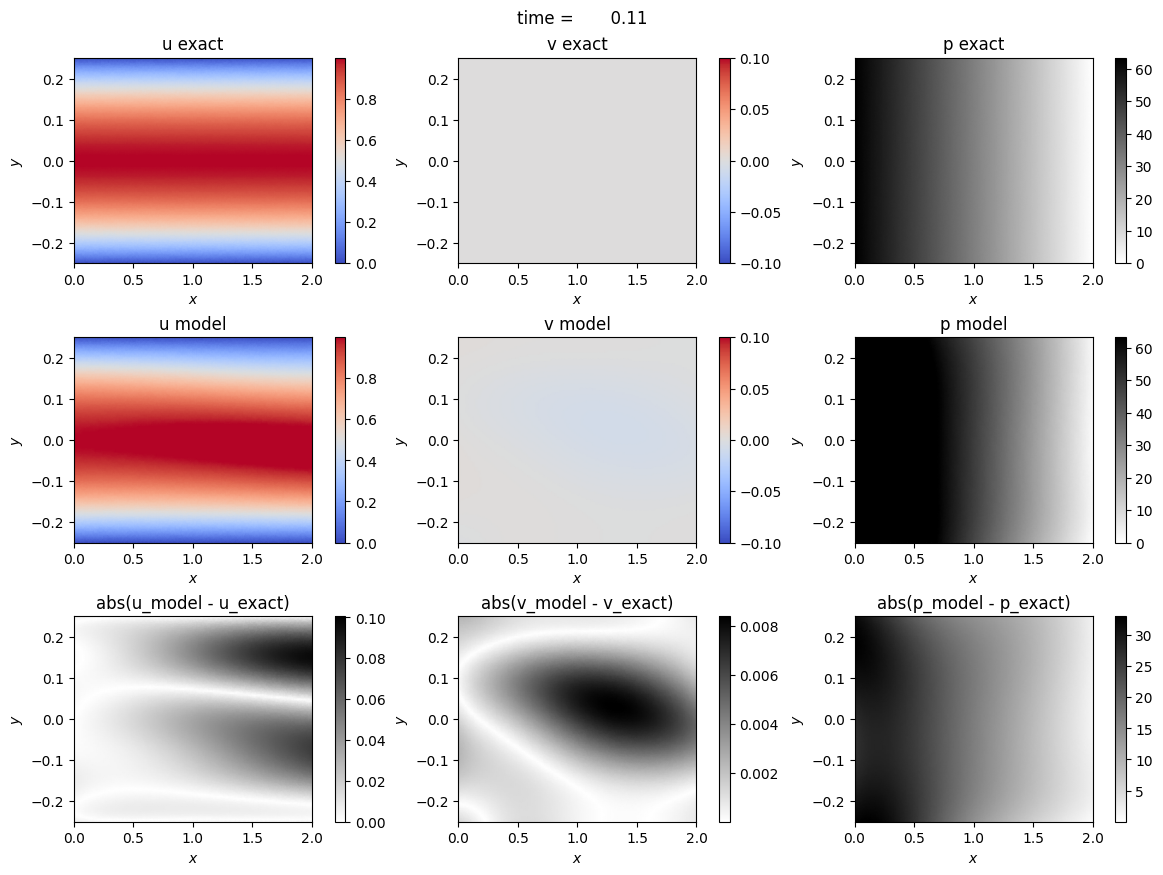

In [44]:
config_baseline = PINNConfig(
# Problem parameters
    xlims = [0.0, 2.0],    # x_min, x_max
    ylims = [-0.25, 0.25],    # y_min, y_max
    tlims = [0.0, 0.11],    # t_min, t_max
    nu = 0.00103,    # кинематическая вязкость (масло касторовое), м2/с
    rho = 960,    # плотность (масло касторовое), кг/м3
    u0 = 1.0,    # начальная скорость в центре потока, м/с

    # Model parameters
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    init_scheme = "glorot_normal",
    layers = [3, 256, 256, 5],   # (x, y) -> (psi, p, sigma_xx, sigma_xy(=sigma_yx), sigma_yy)

    # Training parameters
    results_folder = PINNConfig.results_folder / "baseline",
    n_epochs = 1000,
    n_r = 10000,
    n_batches = 10,   # number of batches per epoch
    lambda_r = 1.0,
    lambda_ic = 1.0,
    lambda_walls = 1.0,
    lambda_inlet = 1.0,
    lambda_outlet = 1.0,
    lr = 1e-3,    # initial learning rate
    use_static_training_set = False,
    logging_freq = 200,    # log metrics once every N gradient descent steps

    # Checkpointing
    use_checkpointing = True,
    checkpointing_freq = 2000,    # save model and metrics to the results_folder once every N gradient descent steps

    # Fourier Feature embedding
    use_FFE = False,
    #FFE_m = 10,
    #FFE_sigma = 1.0,
    #FFE_keep_dims = None,    # Indices of input dimensions to be passed through unchanged

    # Grad norm weighting
    use_grad_norm_weighting = False,
    #grad_norm_weighting_alpha = 0.9,
    #grad_norm_weighting_freq = 250,    # update lambdas once every N gradient descent steps

    # Causal weighting
    #use_causal_weighting_scheme = False,
    #causal_m = 10,
    #causal_eps = 1.0,
    #W_logging_freq = 500,    # log temporal weights and L_t once every N gradient descent steps

    # Video parameters
    render_video = False,
    video_fps = 30,
    video_dpi = 100,
    video_render_freq = 100    # render a frame once every N gradient descent steps
)
model_baseline = MultilayerPerceptronWithFFE(
   config_baseline.layers, config_baseline.init_scheme,
   use_FFE=config_baseline.use_FFE, FFE_m=config_baseline.FFE_m, 
   FFE_sigma=config_baseline.FFE_sigma, FFE_keep_dims=config_baseline.FFE_keep_dims)
optimizer = torch.optim.Adam(model_baseline.parameters(), lr=config_baseline.lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=1)
trainer_baseline = Trainer(model_baseline, optimizer, scheduler, cfg=config_baseline)
print(config_baseline)
metrics_baseline = trainer_baseline.train()

trainer_baseline.render_metrics_plots(metrics_baseline, save_to_disk=True)

Запуск обучения с полным FFE

In [45]:
# config = replace(
#     config_baseline, 
#     results_folder=PINNConfig.results_folder / "FFE_full",
    
#     use_FFE=True,
#     FFE_m=10,
#     FFE_sigma=1.0,
#     FFE_keep_dims=None)
# model_ffe_full = MultilayerPerceptronWithFFE(
#     config.layers, config.init_scheme,
#     use_FFE=config.use_FFE, FFE_m=config.FFE_m, FFE_sigma=config.FFE_sigma, FFE_keep_dims=config.FFE_keep_dims)
# optimizer = torch.optim.Adam(model_ffe_full.parameters(), lr=config.lr)
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=1)
# trainer_ffe_full = Trainer(model_ffe_full, optimizer, scheduler, cfg=config)
# metrics_ffe_full = trainer_ffe_full.train()

# trainer_ffe_full.render_metrics_plots(metrics_ffe_full, save_to_disk=True)

Запуск обучения с частичным FFE для оси Y

In [46]:
# config = replace(
#     config_baseline, results_folder=PINNConfig.results_folder / "FFE_partial",
#     use_FFE=True,
#     FFE_m=10,
#     FFE_sigma=1.0,
#     FFE_keep_dims=[1])
# model_ffe_partial = MultilayerPerceptronWithFFE(
#     config.layers, config.init_scheme,
#     use_FFE=config.use_FFE, FFE_m=config.FFE_m, FFE_sigma=config.FFE_sigma, FFE_keep_dims=config.FFE_keep_dims)
# optimizer = torch.optim.Adam(model_ffe_partial.parameters(), lr=config.lr)
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=1)
# trainer_ffe_partial = Trainer(model_ffe_partial, optimizer, scheduler, cfg=config)
# metrics_ffe_partial = trainer_ffe_partial.train()

# trainer_ffe_partial.render_metrics_plots(metrics_ffe_partial, save_to_disk=True)

Запуск обучения с балансировкой членов loss-функции

In [47]:
# config = replace(
#     config_baseline, 
#     results_folder=PINNConfig.results_folder / "loss_balancing",
    
#     use_grad_norm_weighting=True,
#     grad_norm_weighting_alpha=0.9,
#     grad_norm_weighting_freq=250)
# model_balancing = MultilayerPerceptronWithFFE(
#     config.layers, config.init_scheme,
#     use_FFE=config.use_FFE, FFE_m=config.FFE_m, FFE_sigma=config.FFE_sigma, FFE_keep_dims=config.FFE_keep_dims)
# optimizer = torch.optim.Adam(model_balancing.parameters(), lr=config.lr)
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=1)
# trainer_balancing = Trainer(model_balancing, optimizer, scheduler, cfg=config)
# metrics_balancing = trainer_balancing.train()

# trainer_balancing.render_metrics_plots(metrics_balancing, save_to_disk=True)

Запуск обучения с алгоритмом causal

In [48]:
# config = replace(
#     config_baseline, 
#     results_folder=PINNConfig.results_folder / "causal",
    
#     use_causal_weighting_scheme=True,
#     causal_m=10,
#     causal_eps=10.0,
#     W_logging_freq=500
#     )
# model_causal = MultilayerPerceptronWithFFE(
#     config.layers, config.init_scheme,
#     use_FFE=config.use_FFE, FFE_m=config.FFE_m, FFE_sigma=config.FFE_sigma, FFE_keep_dims=config.FFE_keep_dims)
# optimizer = torch.optim.Adam(model_causal.parameters(), lr=config.lr)
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=1)
# trainer_causal = Trainer(model_causal, optimizer, scheduler, cfg=config)
# metrics_causal = trainer_causal.train()

# trainer_causal.render_metrics_plots(metrics_causal, save_to_disk=True)

Сравнение

In [49]:
# fig, ax = plt.subplots()
# ax.semilogy(metrics_baseline['step'], metrics_baseline['rel_err_l2'], label='baseline')
# ax.semilogy(metrics_ffe_full['step'], metrics_ffe_full['rel_err_l2'], label='ffe_full')
# ax.semilogy(metrics_ffe_partial['step'], metrics_ffe_partial['rel_err_l2'], label='ffe_partial')
# ax.semilogy(metrics_balancing['step'], metrics_balancing['rel_err_l2'], label='balancing')
# #ax.semilogy(metrics_causal['step'], metrics_causal['rel_err_l2'], label='causal')
# ax.set(title="Relative error L2-norm", xlabel="grad step", ylabel="%")
# ax.legend()
# plt.show()
# fig.savefig(PINNConfig.results_folder / "total_rel_err_l2_norm.png", dpi=300)